In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import datetime
from datetime import datetime
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

**Load FAANG Stock Datasets**

In [2]:
from google.colab import files
data_to_load1 = files.upload()
data_to_load2 = files.upload()
data_to_load3 = files.upload()
data_to_load4 = files.upload()
data_to_load5 = files.upload()

Saving Amazon_Historical.csv to Amazon_Historical.csv


Saving Apple_Historical.csv to Apple_Historical.csv


Saving Meta_Historical.csv to Meta_Historical.csv


Saving Google_Alphabet_Historical.csv to Google_Alphabet_Historical.csv


Saving Netflix_Historical.csv to Netflix_Historical.csv


**Read FAANG Stock Datasets in DataFrame**

In [12]:
import io
df_Amazon = pd.read_csv(io.BytesIO(data_to_load1['Amazon_Historical.csv']))
df_Apple = pd.read_csv(io.BytesIO(data_to_load2['Apple_Historical.csv']))
df_Meta = pd.read_csv(io.BytesIO(data_to_load3['Meta_Historical.csv']))
df_Google = pd.read_csv(io.BytesIO(data_to_load4['Google_Alphabet_Historical.csv']))
df_Netflix = pd.read_csv(io.BytesIO(data_to_load5['Netflix_Historical.csv']))

**Amazon Prediction**

Results of dickey fuller test
Test Statistics                   0.149199
p-value                           0.969264
No. of lags used                 27.000000
Number of observations used    2489.000000
critical value (1%)              -3.432980
critical value (5%)              -2.862702
critical value (10%)             -2.567389
dtype: float64
2517
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20299.941, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20291.607, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20292.115, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20303.492, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20291.753, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20285.934, Time=1.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20287.389, Time=2.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20287.208, Time=1.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20293.128, Time=0.66 sec
 AR

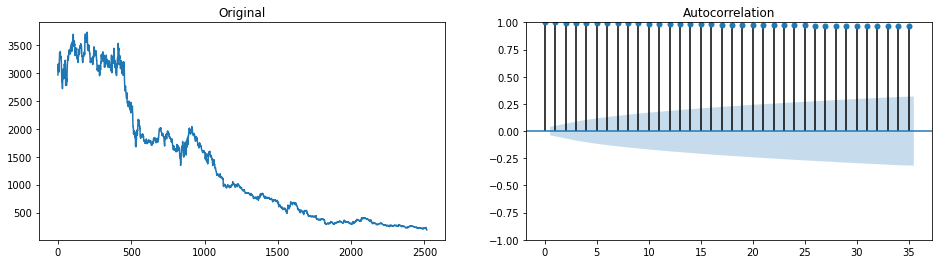

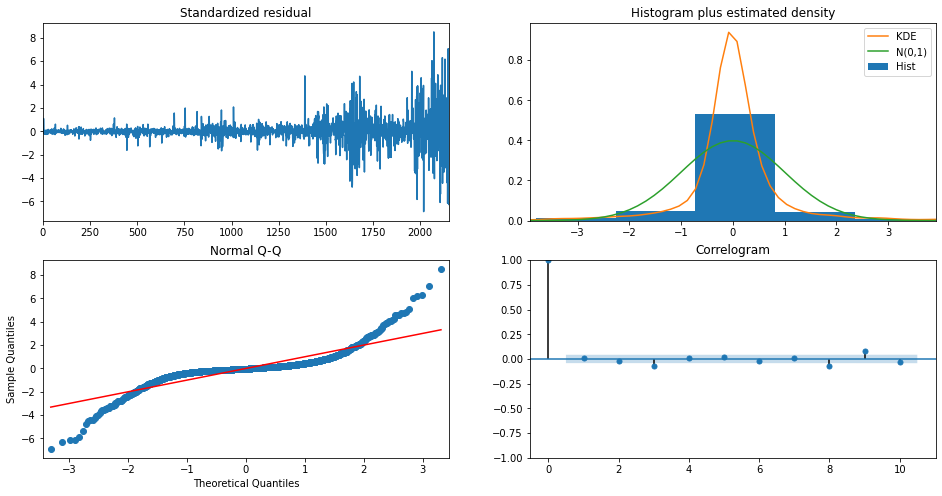

Root mean squared difference between actual and predicted currency of 365 days for Amazon is 269.2912307079949
Mean Absolute difference between actual and predicted currency of 365 days for Amazon is 186.80763209619195


In [24]:
df_Amazon['Close/Last'] = df_Amazon['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
df_Amazon['Open'] = df_Amazon['Open'].replace('[\$,]', '', regex=True).astype(float)
df_Amazon['High'] = df_Amazon['High'].replace('[\$,]', '', regex=True).astype(float)
df_Amazon['Low'] = df_Amazon['Low'].replace('[\$,]', '', regex=True).astype(float)
df_Amazon['Date']=pd.to_datetime(df_Amazon['Date'],errors='coerce')
df_Amazon = df_Amazon.sort_values(by="Date")
data_Amazon=pd.DataFrame(data=df_Amazon['Close/Last'],columns=['Close/Last'])
from sklearn.model_selection import train_test_split
data_Amazon_train,data_Amazon_test = train_test_split(data_Amazon, test_size=365/data_Amazon.shape[0],shuffle=False)
df_Amazon_train,df_Amazon_test = train_test_split(df_Amazon, test_size=365/df_Amazon.shape[0],shuffle=False)

# Dickey Fuller Test
print("Results of dickey fuller test")
adft = adfuller(data_Amazon['Close/Last'])
# output for dft will give us without defining what the values are.
#hence we manually write what values does it explains using a for loop
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
  output['critical value (%s)'%key] =  values
print(output)
difference = ndiffs(data_Amazon['Close/Last'], test="adf")
#Relation between Original and Auto-Correlation
fig,( ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(data_Amazon['Close/Last'])
ax1.set_title("Original")
#ax2.set_ylim(0,1)
plot_acf(data_Amazon['Close/Last'],ax=ax2)
print(len(data_Amazon['Close/Last']))
diff= df_Amazon.copy().diff().dropna()

model = auto_arima(data_Amazon_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=2, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
  
model.fit(data_Amazon_train)
print(model.summary)
model.plot_diagnostics(figsize=(16,8))
plt.show()

# Forecast
fc = model.predict(len(data_Amazon_test))  # 95% conf
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
rms = sqrt(mean_squared_error(df_Amazon_test['Close/Last'],fc))
ma =mean_absolute_error(df_Amazon_test['Close/Last'],fc)
print("Root mean squared difference between actual and predicted currency of 365 days for Amazon is",rms)
print("Mean Absolute difference between actual and predicted currency of 365 days for Amazon is",ma)
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_Amazon.Date, y=df_Amazon['Close/Last'], name="Actual Value",
                         line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=df_Amazon_test.Date, y=fc, name="Predicted Value",
                         line_color='dimgray'))
fig.update_layout(title_text='Amazon ARIMA Forecasting',
                  xaxis_rangeslider_visible=True)
fig.show()


**Apple Prediction**

Results of dickey fuller test
Test Statistics                   1.600005
p-value                           0.997858
No. of lags used                 20.000000
Number of observations used    2496.000000
critical value (1%)              -3.432973
critical value (5%)              -2.862699
critical value (10%)             -2.567387
dtype: float64
2517
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6073.462, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6035.758, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6039.553, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6076.020, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6032.930, Time=0.67 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6034.348, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6034.668, Time=1.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6033.166, Time=0.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6036.245, Time=1.32 sec
 ARIMA(2,1,0

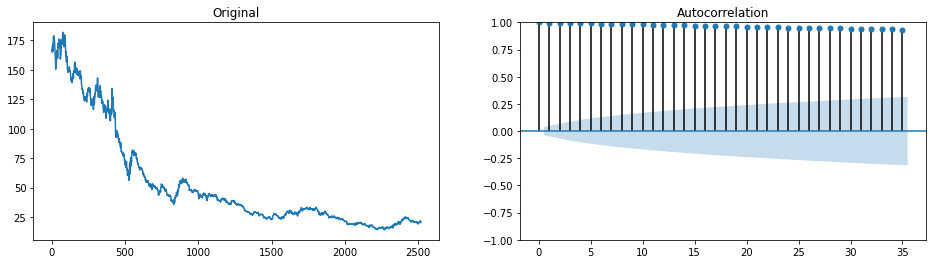

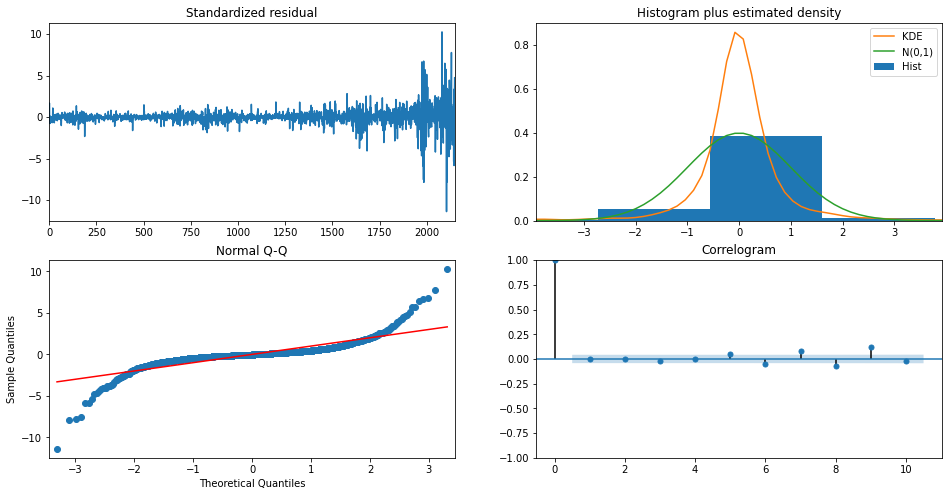

Root mean squared difference between actual and predicted currency of 365 days for Apple is 22.56608362869045
Mean Absolute difference between actual and predicted currency of 365 days for Apple is 18.03891736500706


In [28]:
df_Apple['Close/Last'] = df_Apple['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
df_Apple['Open'] = df_Apple['Open'].replace('[\$,]', '', regex=True).astype(float)
df_Apple['High'] = df_Apple['High'].replace('[\$,]', '', regex=True).astype(float)
df_Apple['Low'] = df_Apple['Low'].replace('[\$,]', '', regex=True).astype(float)
df_Apple['Date']=pd.to_datetime(df_Apple['Date'],errors='coerce')
df_Apple = df_Apple.sort_values(by="Date")
data_Apple=pd.DataFrame(data=df_Apple['Close/Last'],columns=['Close/Last'])
from sklearn.model_selection import train_test_split
data_Apple_train,data_Apple_test = train_test_split(data_Apple, test_size=365/data_Apple.shape[0],shuffle=False)
df_Apple_train,df_Apple_test = train_test_split(df_Apple, test_size=365/df_Apple.shape[0],shuffle=False)

# Dickey Fuller Test
print("Results of dickey fuller test")
adft = adfuller(data_Apple['Close/Last'])
# output for dft will give us without defining what the values are.
#hence we manually write what values does it explains using a for loop
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
  output['critical value (%s)'%key] =  values
print(output)
difference = ndiffs(data_Apple['Close/Last'], test="adf")
#Relation between Original and Auto-Correlation
fig,( ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(data_Apple['Close/Last'])
ax1.set_title("Original")
#ax2.set_ylim(0,1)
plot_acf(data_Apple['Close/Last'],ax=ax2)
print(len(data_Apple['Close/Last']))
diff= df_Apple.copy().diff().dropna()

model = auto_arima(data_Apple_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=2, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
  
model.fit(data_Apple_train)
print(model.summary)
model.plot_diagnostics(figsize=(16,8))
plt.show()

# Forecast
fc = model.predict(len(data_Apple_test))  # 95% conf
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
rms = sqrt(mean_squared_error(df_Apple_test['Close/Last'],fc))
ma =mean_absolute_error(df_Apple_test['Close/Last'],fc)
print("Root mean squared difference between actual and predicted currency of 365 days for Apple is",rms)
print("Mean Absolute difference between actual and predicted currency of 365 days for Apple is",ma)
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_Apple.Date, y=df_Apple['Close/Last'], name="Actual Value",
                         line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=df_Apple_test.Date, y=fc, name="Predicted Value",
                         line_color='dimgray'))
fig.update_layout(title_text='Apple ARIMA Forecasting',
                  xaxis_rangeslider_visible=True)
fig.show()


**Meta Prediction**

Results of dickey fuller test
Test Statistics                  -1.510581
p-value                           0.528271
No. of lags used                 18.000000
Number of observations used    2479.000000
critical value (1%)              -3.432991
critical value (5%)              -2.862707
critical value (10%)             -2.567391
dtype: float64
2498
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10753.202, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10743.287, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10743.938, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10754.571, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10743.161, Time=0.82 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10732.772, Time=1.01 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10733.931, Time=1.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10739.432, Time=1.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=10735.001, Time=0.19 sec

Be

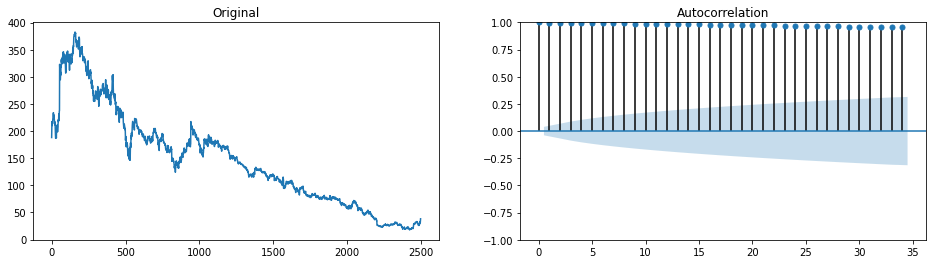

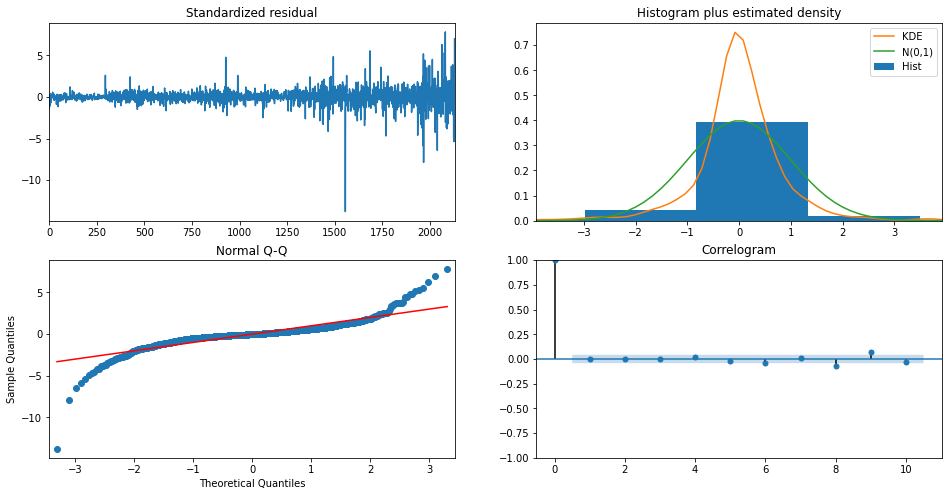

Root mean squared difference between actual and predicted currency of 365 days for Meta is 53.175037752591
Mean Absolute difference between actual and predicted currency of 365 days for Meta is 37.915690462845944


In [29]:
df_Meta['Close/Last'] = df_Meta['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
df_Meta['Open'] = df_Meta['Open'].replace('[\$,]', '', regex=True).astype(float)
df_Meta['High'] = df_Meta['High'].replace('[\$,]', '', regex=True).astype(float)
df_Meta['Low'] = df_Meta['Low'].replace('[\$,]', '', regex=True).astype(float)
df_Meta['Date']=pd.to_datetime(df_Meta['Date'],errors='coerce')
df_Meta = df_Meta.sort_values(by="Date")
data_Meta=pd.DataFrame(data=df_Meta['Close/Last'],columns=['Close/Last'])
from sklearn.model_selection import train_test_split
data_Meta_train,data_Meta_test = train_test_split(data_Meta, test_size=365/data_Meta.shape[0],shuffle=False)
df_Meta_train,df_Meta_test = train_test_split(df_Meta, test_size=365/df_Meta.shape[0],shuffle=False)

# Dickey Fuller Test
print("Results of dickey fuller test")
adft = adfuller(data_Meta['Close/Last'])
# output for dft will give us without defining what the values are.
#hence we manually write what values does it explains using a for loop
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
  output['critical value (%s)'%key] =  values
print(output)
difference = ndiffs(data_Meta['Close/Last'], test="adf")
#Relation between Original and Auto-Correlation
fig,( ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(data_Meta['Close/Last'])
ax1.set_title("Original")
#ax2.set_ylim(0,1)
plot_acf(data_Meta['Close/Last'],ax=ax2)
print(len(data_Meta['Close/Last']))
diff= df_Meta.copy().diff().dropna()

model = auto_arima(data_Meta_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=2, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
  
model.fit(data_Meta_train)
print(model.summary)
model.plot_diagnostics(figsize=(16,8))
plt.show()

# Forecast
fc = model.predict(len(data_Meta_test))  # 95% conf
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
rms = sqrt(mean_squared_error(df_Meta_test['Close/Last'],fc))
ma =mean_absolute_error(df_Meta_test['Close/Last'],fc)
print("Root mean squared difference between actual and predicted currency of 365 days for Meta is",rms)
print("Mean Absolute difference between actual and predicted currency of 365 days for Meta is",ma)
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_Meta.Date, y=df_Meta['Close/Last'], name="Actual Value",
                         line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=df_Meta_test.Date, y=fc, name="Predicted Value",
                         line_color='dimgray'))
fig.update_layout(title_text='Meta ARIMA Forecasting',
                  xaxis_rangeslider_visible=True)
fig.show()


**Google Prediction**

Results of dickey fuller test
Test Statistics                   0.674454
p-value                           0.989314
No. of lags used                 23.000000
Number of observations used    2009.000000
critical value (1%)              -3.433609
critical value (5%)              -2.862980
critical value (10%)             -2.567536
dtype: float64
2033
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14281.429, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14260.716, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14261.452, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14282.255, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14262.587, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14262.615, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14264.523, Time=3.72 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14262.281, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 6.032 s

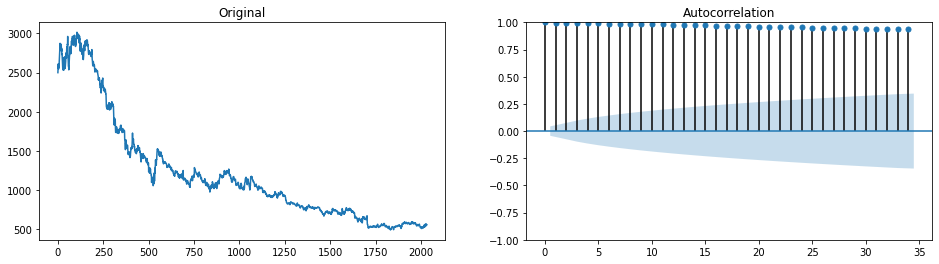

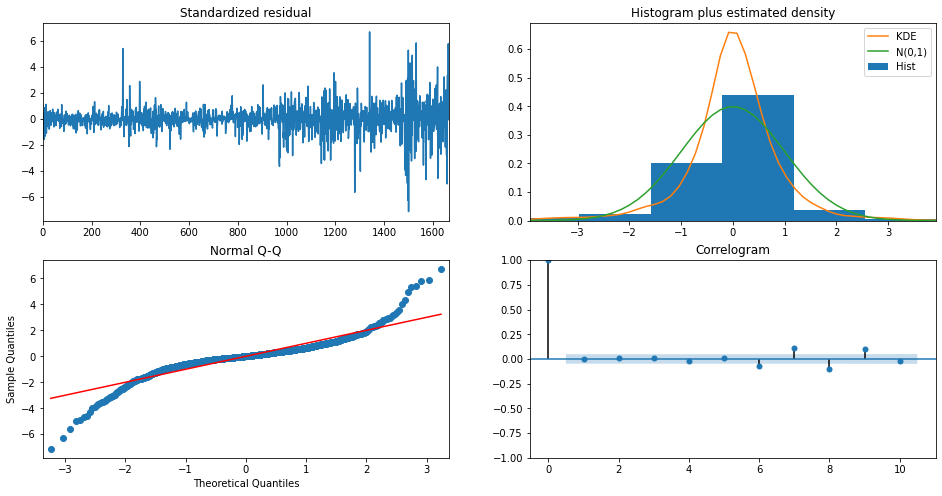

Root mean squared difference between actual and predicted currency of 365 days for Google is 671.7147370143972
Mean Absolute difference between actual and predicted currency of 365 days for Google is 587.9313100599055


In [30]:
df_Google['Close/Last'] = df_Google['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
df_Google['Open'] = df_Google['Open'].replace('[\$,]', '', regex=True).astype(float)
df_Google['High'] = df_Google['High'].replace('[\$,]', '', regex=True).astype(float)
df_Google['Low'] = df_Google['Low'].replace('[\$,]', '', regex=True).astype(float)
df_Google['Date']=pd.to_datetime(df_Google['Date'],errors='coerce')
df_Google = df_Google.sort_values(by="Date")
data_Google=pd.DataFrame(data=df_Google['Close/Last'],columns=['Close/Last'])
from sklearn.model_selection import train_test_split
data_Google_train,data_Google_test = train_test_split(data_Google, test_size=365/data_Google.shape[0],shuffle=False)
df_Google_train,df_Google_test = train_test_split(df_Google, test_size=365/df_Google.shape[0],shuffle=False)

# Dickey Fuller Test
print("Results of dickey fuller test")
adft = adfuller(data_Google['Close/Last'])
# output for dft will give us without defining what the values are.
#hence we manually write what values does it explains using a for loop
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
  output['critical value (%s)'%key] =  values
print(output)
difference = ndiffs(data_Google['Close/Last'], test="adf")
#Relation between Original and Auto-Correlation
fig,( ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(data_Google['Close/Last'])
ax1.set_title("Original")
#ax2.set_ylim(0,1)
plot_acf(data_Google['Close/Last'],ax=ax2)
print(len(data_Google['Close/Last']))
diff= df_Google.copy().diff().dropna()

model = auto_arima(data_Google_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=2, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
  
model.fit(data_Google_train)
print(model.summary)
model.plot_diagnostics(figsize=(16,8))
plt.show()

# Forecast
fc = model.predict(len(data_Google_test))  # 95% conf
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
rms = sqrt(mean_squared_error(df_Google_test['Close/Last'],fc))
ma =mean_absolute_error(df_Google_test['Close/Last'],fc)
print("Root mean squared difference between actual and predicted currency of 365 days for Google is",rms)
print("Mean Absolute difference between actual and predicted currency of 365 days for Google is",ma)
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_Google.Date, y=df_Google['Close/Last'], name="Actual Value",
                         line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=df_Google_test.Date, y=fc, name="Predicted Value",
                         line_color='dimgray'))
fig.update_layout(title_text='Google ARIMA Forecasting',
                  xaxis_rangeslider_visible=True)
fig.show()


**Netflix Prediction**

Results of dickey fuller test
Test Statistics                  -1.334362
p-value                           0.613309
No. of lags used                 22.000000
Number of observations used    2494.000000
critical value (1%)              -3.432975
critical value (5%)              -2.862700
critical value (10%)             -2.567387
dtype: float64
2517
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13802.482, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13782.187, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13784.933, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13803.732, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13774.884, Time=0.73 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13776.880, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13774.212, Time=2.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13772.322, Time=1.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13774.215, Time=1.93 sec
 AR

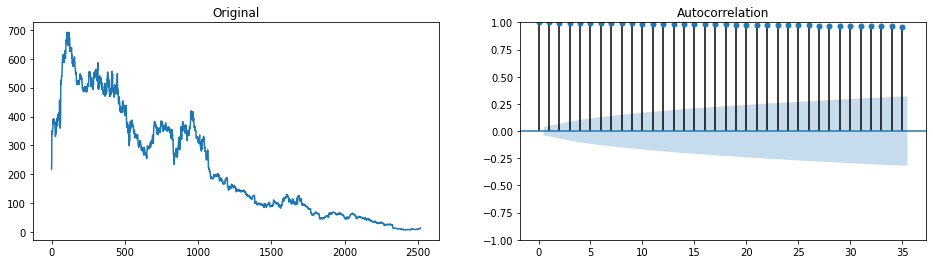

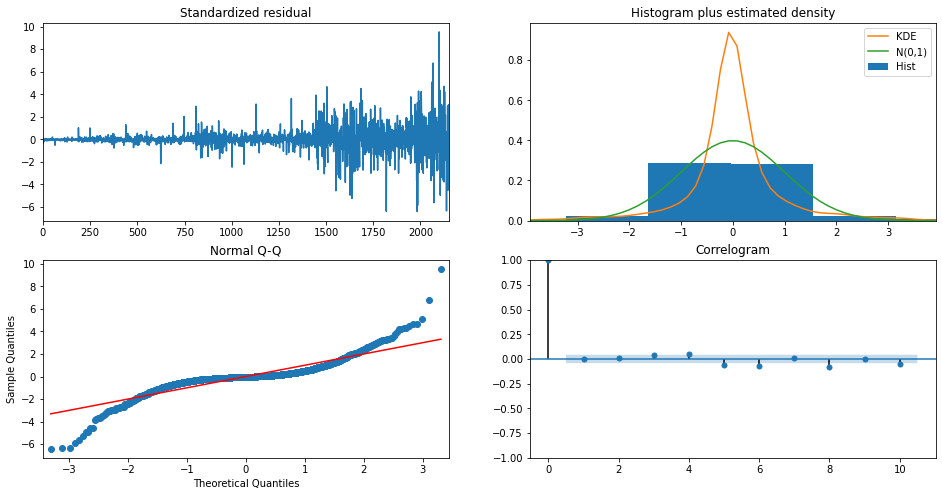

Root mean squared difference between actual and predicted currency of 365 days for Netflix is 100.84099661178334
Mean Absolute difference between actual and predicted currency of 365 days for Netflix is 67.41440926920266


In [31]:
df_Netflix['Close/Last'] = df_Netflix['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
df_Netflix['Open'] = df_Netflix['Open'].replace('[\$,]', '', regex=True).astype(float)
df_Netflix['High'] = df_Netflix['High'].replace('[\$,]', '', regex=True).astype(float)
df_Netflix['Low'] = df_Netflix['Low'].replace('[\$,]', '', regex=True).astype(float)
df_Netflix['Date']=pd.to_datetime(df_Netflix['Date'],errors='coerce')
df_Netflix = df_Netflix.sort_values(by="Date")
data_Netflix=pd.DataFrame(data=df_Netflix['Close/Last'],columns=['Close/Last'])
from sklearn.model_selection import train_test_split
data_Netflix_train,data_Netflix_test = train_test_split(data_Netflix, test_size=365/data_Netflix.shape[0],shuffle=False)
df_Netflix_train,df_Netflix_test = train_test_split(df_Netflix, test_size=365/df_Netflix.shape[0],shuffle=False)

# Dickey Fuller Test
print("Results of dickey fuller test")
adft = adfuller(data_Netflix['Close/Last'])
# output for dft will give us without defining what the values are.
#hence we manually write what values does it explains using a for loop
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
  output['critical value (%s)'%key] =  values
print(output)
difference = ndiffs(data_Netflix['Close/Last'], test="adf")
#Relation between Original and Auto-Correlation
fig,( ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(data_Netflix['Close/Last'])
ax1.set_title("Original")
#ax2.set_ylim(0,1)
plot_acf(data_Netflix['Close/Last'],ax=ax2)
print(len(data_Netflix['Close/Last']))
diff= df_Netflix.copy().diff().dropna()




model = auto_arima(data_Netflix_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=2, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
  
model.fit(data_Netflix_train)
print(model.summary)
model.plot_diagnostics(figsize=(16,8))
plt.show()
# Forecast
fc = model.predict(len(data_Netflix_test))  # 95% conf
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
rms = sqrt(mean_squared_error(df_Netflix_test['Close/Last'],fc))
ma =mean_absolute_error(df_Netflix_test['Close/Last'],fc)
print("Root mean squared difference between actual and predicted currency of 365 days for Netflix is",rms)
print("Mean Absolute difference between actual and predicted currency of 365 days for Netflix is",ma)
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_Netflix.Date, y=df_Netflix['Close/Last'], name="Actual Value",
                         line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=df_Netflix_test.Date, y=fc, name="Predicted Value",
                         line_color='dimgray'))
fig.update_layout(title_text='Netflix ARIMA Forecasting',
                  xaxis_rangeslider_visible=True)
fig.show()
